In [1]:
import time
notebook_start_time = time.time()

In [2]:
import sys
from pathlib import Path

root_dir = str(Path().absolute().parent)
sys.path.append(root_dir)

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
!pip install tf_keras==2.17.0


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [18]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

from loguru import logger

from recsys.hopsworks_integration import feature_store, two_tower_serving
from recsys.config import settings
from recsys.training.two_tower import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Connect to Hopsworks Feature Store 

In [5]:
project, fs = feature_store.get_feature_store()

2025-08-12 16:45:30.417 | INFO     | recsys.hopsworks_integration.feature_store:get_feature_store:10 - Loging to Hopsworks using HOPSWORKS_API_KEY env var.


2025-08-12 16:45:30,419 INFO: Initializing external client
2025-08-12 16:45:30,419 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-08-12 16:45:32,176 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/90261


## Create Hopsworks Feature Views

In [6]:
feature_view = feature_store.create_retrieval_feature_view(fs)

## Create training dataset

In [7]:
dataset = TwoTowerDataset(
    feature_view=feature_view, batch_size=settings.TWO_TOWER_MODEL_BATCH_SIZE
)
train_ds, val_ds = dataset.get_train_val_split()

2025-08-12 16:45:38.095 | INFO     | recsys.training.two_tower:get_train_val_split:43 - Retrieving and creating train, val test split...


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.16s) 


I0000 00:00:1755009950.951920   30844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-12 16:45:51.208791: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
logger.info(f"Training samples: {len(dataset.properties['train_df']):,}")
logger.info(f"Validation samples: {len(dataset.properties['val_df']):,}")

logger.info(f"Number of users: {len(dataset.properties['user_ids']):,}")
logger.info(f"Number of items: {len(dataset.properties['item_ids']):,}")

2025-08-12 16:45:51.298 | INFO     | __main__:<module>:1 - Training samples: 16,300
2025-08-12 16:45:51.299 | INFO     | __main__:<module>:2 - Validation samples: 2,037
2025-08-12 16:45:51.300 | INFO     | __main__:<module>:4 - Number of users: 959
2025-08-12 16:45:51.301 | INFO     | __main__:<module>:5 - Number of items: 11,842


In [9]:
dataset.properties["train_df"].head()

,customer_id,article_id,t_dat,price,month_sin,month_cos,age,club_member_status,age_group,garment_group_name,index_group_name
0,f7048acb8188d98bde3a5c495475a3c86faafe0eede1f2...,670265002,0,0.013542,-8.660254e-01,0.500000,48.0,ACTIVE,46-55,"Under-, Nightwear",Ladieswear
1,5d34f84e6cbe9ec4706872bb65376097af1e53f0c7dac5...,751471035,0,0.033881,1.224647e-16,-1.000000,30.0,ACTIVE,26-35,Trousers,Ladieswear
2,baf6dc7ea8575732794751bb80824fe84fd40e6af86193...,719308002,0,0.059305,5.000000e-01,-0.866025,48.0,ACTIVE,46-55,Dresses Ladies,Divided
3,288a5255c2c11ba15d0585466a85900e4f334b2b19184e...,759231002,0,0.059305,1.224647e-16,-1.000000,77.0,ACTIVE,66+,Dresses Ladies,Ladieswear
5,19ed12b3909e6d4fdb7e858c894d102e02d88691e98cf3...,793911001,0,0.033881,1.224647e-16,-1.000000,29.0,ACTIVE,26-35,Blouses,Ladieswear


## Build the Two Tower model

In [10]:
query_model_factory = QueryTowerFactory(dataset=dataset)
query_model = query_model_factory.build()

In [11]:
item_model_factory = ItemTowerFactory(dataset=dataset)
item_model = item_model_factory.build()

In [12]:
model_factory = TwoTowerFactory(dataset=dataset)
model = model_factory.build(query_model=query_model, item_model=item_model)

In [13]:
trainer = TwoTowerTrainer(dataset=dataset, model=model)
history = trainer.train(train_ds, val_ds)

Epoch 1/10
8/8 [==============================] - 1s 59ms/step - loss: 15511.3829 - regularization_loss: 0.0000e+00 - total_loss: 15511.3829 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - val_loss: 15437.3203 - val_regularization_loss: 0.0000e+00 - val_total_loss: 15437.3203
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 15257.7411 - regularization_loss: 0.0000e+00 - total_loss: 15257.7411 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 

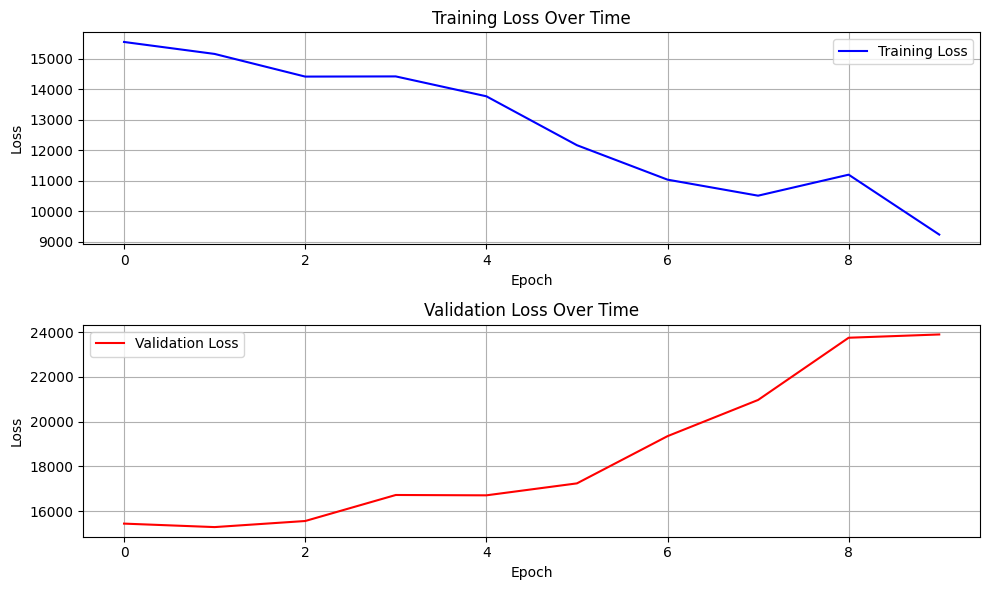

In [14]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Training loss subplot
ax1.plot(history.history["loss"], label="Training Loss", color="blue")
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Validation loss subplot
ax2.plot(history.history["val_loss"], label="Validation Loss", color="red")
ax2.set_title("Validation Loss Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()



# Upload models to Hopsworks model registry 

In [15]:
mr = project.get_model_registry()

In [19]:
query_model = two_tower_serving.HopsworksQueryModel(
    model=model.query_model
)
query_model.register(
    mr=mr,
    feature_view=feature_view,
    query_df=dataset.properties["query_df"],
)

item_model = two_tower_serving.HopsworksCandidateModel(
    model=model.item_model
)
item_model.register(
    mr=mr,
    feature_view=feature_view,
    item_df=dataset.properties["item_df"],
)

2025-08-12 16:57:30,556 INFO: Function `compute_embedding` contains input name(s) table_handle, 3774, resource with unsupported characters which will be renamed to query_tower_sequential_string_lookup_none_lookup_lookuptablefindv2_table_handle, query_tower_sequential_embedding_embedding_lookup_3774, query_tower_sequential_1_dense_1_biasadd_readvariableop_resource in the SavedModel.
2025-08-12 16:57:30,883 INFO: Assets written to: query_model/assets


Uploading /home/massyl/projects/personalized-recommender-project/notebooks/query_model/saved_model.pb: 100.000%|██████████| 179296/179296 elapsed<00:02 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/query_model/fingerprint.pb: 100.000%|██████████| 56/56 elapsed<00:01 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/query_model/variables/variables.data-00000-of-00001: 100.000%|██████████| 69050/69050 elapsed<00:01 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/query_model/variables/variables.index: 100.000%|██████████| 561/561 elapsed<00:01 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/input_example.json: 100.000%|██████████| 166/166 elapsed<00:01 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/model_schema.json: 100.000%|██████████| 852/852 elapsed<00:01 remaining<00:00
M

Model created, explore it at https://c.app.hopsworks.ai:443/p/90261/models/query_model/1
2025-08-12 16:57:53,337 INFO: Assets written to: candidate_model/assets


Uploading /home/massyl/projects/personalized-recommender-project/notebooks/candidate_model/saved_model.pb: 100.000%|██████████| 326323/326323 elapsed<00:02 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/candidate_model/fingerprint.pb: 100.000%|██████████| 56/56 elapsed<00:01 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/candidate_model/variables/variables.data-00000-of-00001: 100.000%|██████████| 767146/767146 elapsed<00:03 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/candidate_model/variables/variables.index: 100.000%|██████████| 423/423 elapsed<00:01 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/input_example.json: 100.000%|██████████| 97/97 elapsed<00:01 remaining<00:00
Uploading /home/massyl/projects/personalized-recommender-project/notebooks/model_schema.json: 100.000%|██████████| 852/852 elapsed<00:01 r

Model created, explore it at https://c.app.hopsworks.ai:443/p/90261/models/candidate_model/1


In [20]:
notebook_end_time = time.time()
notebook_execution_time = notebook_end_time - notebook_start_time

logger.info(
    f"⌛️ Notebook Execution time: {notebook_execution_time:.2f} seconds ~ {notebook_execution_time / 60:.2f} minutes"
)

2025-08-12 16:58:22.255 | INFO     | __main__:<module>:4 - ⌛️ Notebook Execution time: 789.49 seconds ~ 13.16 minutes
